In [ ]:
# IMPORTANT! First, go to Runtime -> Change runtime type, select a GPU runtime
# And then Runtime -> Run all
!pip install git+https://github.com/Rottenham/PvZ-Emulator

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Cloning https://github.com/Rottenham/PvZ-Emulator to /tmp/pip-req-build-cyyi78n3
  Running command git clone -q https://github.com/Rottenham/PvZ-Emulator /tmp/pip-req-build-cyyi78n3
  Running command git submodule update --init --recursive -q


In [ ]:
from enum import Enum


class GameStatus(Enum):
    CONTINUE = 0
    WIN = 1
    LOSE = 2
    TIMEUP = 3


N_LANES = 5  # Height
LANE_LENGTH = 9  # Width
P_LANE_LENGTH = 4
N_PLANT_TYPE = 4
N_ZOMBIE_TYPE = 3
SUN_MAX = 1950

# action
ACTION_SIZE = N_ZOMBIE_TYPE * N_LANES + 1

# state
NUM_ZOMBIES = 39
NUM_PLANTS = 20
ZOMBIE_SIZE = 6
PLANT_SIZE = 4
BRAIN_BASE = NUM_ZOMBIES * ZOMBIE_SIZE + NUM_PLANTS * PLANT_SIZE + 1  # extra 1 for sun
BRAIN_SIZE = 5
STATE_SIZE = BRAIN_BASE + BRAIN_SIZE


In [ ]:
import numpy as np

from pvzemu import (
    World,
    SceneType,
    ZombieType,
    PlantType,
    IZObservation,
)

plant_counts = {
    PlantType.sunflower: 9,
    PlantType.pea_shooter: 6,
    PlantType.squash: 3,
    PlantType.snow_pea: 2,
}

zombie_deck = [
    [ZombieType.zombie, 50],
    [ZombieType.buckethead, 125],
    [ZombieType.football, 175],
]


class IZenv:
    def __init__(self, step_length=50, max_step=None, fix_rand=False):
        self.step_length = step_length
        self.max_step = max_step
        self.fix_rand = fix_rand

        self.ob_factory = IZObservation(NUM_ZOMBIES, NUM_PLANTS)
        self.state = []
        self.zombie_count, self.plant_count, self.brains = 0, 0, [0, 1, 2, 3, 4]

        self.step_count = 0
        self.world = World(SceneType.night)
        self._reset_world()

    def reset(self) -> None:
        self.zombie_count, self.plant_count, self.brains = 0, 0, [0, 1, 2, 3, 4]
        self.step_count = 0
        self._reset_world()

    def get_state_and_mask(self):
        return self.state, self.get_action_mask()

    def step(self, action):
        self.step_count += 1
        prev = {
            "sun_before_action": self.get_sun(),
            "zombie_count": self.zombie_count,
            "plant_count": self.plant_count,
            "brain_count": len(self.brains),
        }

        self._take_action(action)
        prev["sun_after_action"] = self.get_sun()

        for _ in range(self.step_length):
            self.world.update()
        self._update_state()

        game_status = self._get_game_status()
        return (
            self._get_reward(prev, action, game_status),
            self.state,
            self.get_action_mask(),
            game_status,
        )

    def get_valid_actions(self, action_mask):
        actions = np.arange(ACTION_SIZE)
        return actions[action_mask]

    def get_action_mask(self):
        sun = self.get_sun()
        mask = np.zeros(ACTION_SIZE, dtype=bool)
        if self.zombie_count > 0:
            mask[0] = True
        if sun >= 50:
            mask[1:6] = True
        if sun >= 125:
            mask[6:11] = True
        if sun >= 175:
            mask[11:16] = True
        for row in range(5):
            if not row in self.brains:
                for i in range(3):
                    mask[i * 5 + row + 1] = False
        return mask

    def get_sun(self):
        return self.world.scene.sun.sun

    def _get_game_status(self):
        if self.max_step is not None and self.step_count >= self.max_step:
            return GameStatus.TIMEUP
        if len(self.brains) == 0:
            return GameStatus.WIN
        if self.get_sun() < 50 and self.zombie_count == 0:
            return GameStatus.LOSE
        return GameStatus.CONTINUE

    def _get_reward_plain(self, prev, game_status):
        if game_status == GameStatus.LOSE:
            return -72
        return (self.get_sun() - prev["sun_before_action"]) / 25

    def _get_reward(self, prev, action, game_status):
        # return self._get_reward_plain(prev, game_status)

        # earned_sun = self.get_sun() - prev["sun_after_action"]
        # eaten_plant_num = prev["plant_count"] - self.plant_count
        # eaten_brain_num = prev["brain_count"] - len(self.brains)

        reward = (self.get_sun() - prev["sun_before_action"]) / 25
        # reward += eaten_brain_num * 8
        # if game_status == GameStatus.WIN:
        #     reward += self.get_sun() / 25
        # if game_status == GameStatus.LOSE:
        #     reward = -72
        return reward

    def _reset_world(self) -> None:
        self.world = World(SceneType.night)
        self.world.scene.stop_spawn = True
        self.world.scene.is_iz = True
        self.world.scene.set_sun(150)
        plant_list = [
            plant for plant, count in plant_counts.items() for _ in range(count)
        ]
        if self.fix_rand:
            np.random.seed(0)
        np.random.shuffle(plant_list)
        for index, plant in enumerate(plant_list):
            self.world.plant_factory.create(
                plant,
                index // P_LANE_LENGTH,
                index % P_LANE_LENGTH,
            )
        self._update_state()

    def _take_action(self, action):
        if action > 0:
            action -= 1
            z_idx = action // N_LANES
            row = action % N_LANES
            col = 4
            sun = self.get_sun() - zombie_deck[z_idx][1]
            assert sun >= 0
            self.world.zombie_factory.create(zombie_deck[z_idx][0], row, col)
            self.world.scene.set_sun(sun)

    def _update_state(self):
        self.state, self.zombie_count, self.plant_count = self.ob_factory.create(
            self.world
        )

        self.brains = []
        for i, b in enumerate(self.state[BRAIN_BASE : BRAIN_BASE + 5]):
            if b > 0.5:
                self.brains.append(i)

    def print_human_readable_state(self, highlight=None):
        def plant_str(plant_type):
            if plant_type == 1:
                return "sun"
            if plant_type == 2:
                return "pea"
            if plant_type == 3:
                return "sqa"
            if plant_type == 4:
                return "sno"
            return "---"

        def zombie_x_to_col(x):
            col = int((x + 40) // 80)
            return min(max(col, 0), LANE_LENGTH - 1)

        def zombie_str(zombie_type):
            if zombie_type == 1:
                return "Z"
            if zombie_type == 2:
                return "B"
            if zombie_type == 3:
                return "F"
            return "."

        def acc1_hp_max(zombie_type):
            if zombie_type == 2:
                return 1100
            if zombie_type == 3:
                return 1400
            return 0

        plant_hps = [[0 for _ in range(P_LANE_LENGTH)] for _ in range(N_LANES)]
        plant_types = [["---" for _ in range(P_LANE_LENGTH)] for _ in range(N_LANES)]
        zombie_hps = [[0 for _ in range(LANE_LENGTH)] for _ in range(N_LANES)]
        zombie_types = [["." for _ in range(LANE_LENGTH)] for _ in range(N_LANES)]

        state = self.state

        for i in range(NUM_PLANTS):
            base = NUM_ZOMBIES * ZOMBIE_SIZE + i * PLANT_SIZE
            if state[base] != 0:
                plant_type = int(round(state[base] * 4))
                hp = state[base + 1]
                row = int(round(state[base + 2] * 5))
                col = int(round(state[base + 3] * 9))

                plant_hps[row][col] += hp * 300
                plant_types[row][col] = plant_str(plant_type)

        for i in range(NUM_ZOMBIES):
            base = i * ZOMBIE_SIZE
            if state[base] != 0:
                zombie_type = int(round(state[base] * 3))
                x = state[base + 1] * 650
                row = int(round(state[base + 2] * 5))
                hp = state[base + 3]
                acc1_hp = state[base + 4]
                col = zombie_x_to_col(x)

                zombie_hps[row][col] += hp * 270 + acc1_hp * acc1_hp_max(zombie_type)
                zombie_types[row][col] = zombie_str(zombie_type)

        print("==Plant HP==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(P_LANE_LENGTH):
                print(f"{plant_hps[row][col]:.2f}\t", end="")
            print()

        print("==Plant Type==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(P_LANE_LENGTH):
                print(f"{plant_types[row][col]}\t", end="")
            print()

        print("==Zombie HP==")
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(LANE_LENGTH):
                print(f"{zombie_hps[row][col]:.2f}\t", end="")
            print()

        print("==Zombie Type==")
        highlight_row, highlight_col = (-1, -1) if highlight is None else highlight
        for row in range(N_LANES):
            print(f"row {row+1}: ", end="")
            for col in range(LANE_LENGTH):
                out = f"{zombie_types[row][col]}"
                if row == highlight_row and col == highlight_col:
                    out = f"[{out}]"
                out += "\t"
                print(out, end="")
            print()

        print(
            f"Step: {self.step_count}; Sun: {self.get_sun()}; Brains: {len(self.brains)}; Game status: {self._get_game_status().name} "
        )


In [ ]:
import warnings


class Epsilons:
    def __init__(
        self,
        seq_length,
        start_epsilon,
        end_epsilon,
        interpolation="exponential",
    ):
        self.seq_length = seq_length
        self.start_epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.interpolation = interpolation

        assert seq_length > 1, "seq_length must be positive"
        assert interpolation in ["exponential"], "not implemented"

        self.index = 0
        self.decay_rate = (self.end_epsilon / self.start_epsilon) ** (
            1 / (self.seq_length - 1)
        )
        self.has_warned = False

    def get(self):
        return self.start_epsilon * self.decay_rate**self.index

    def next(self):
        self.index += 1
        if self.index >= self.seq_length:
            if not self.has_warned:
                self.has_warned = True
                warnings.warn(
                    f"index = {self.index} overflows for seq_length = {self.seq_length}, using index = {self.seq_length - 1}."
                )
            self.index = self.seq_length - 1

In [ ]:
from collections import Counter
import numpy as np

def evaluate_agent(
    agent, max_step=100_000, test_size=500, episode_count=None, output_file=None
):
    agent.set_to_eval_mode()
    game_results = []
    steps = []
    winning_suns = []

    for test_idx in range(test_size):
        print(f"\rTesting {test_idx}/{test_size}...", end="")
        env = IZenv(max_step=max_step)
        state, mask = env.get_state_and_mask()

        for step in range(max_step + 1):
            action = agent.get_best_q_action(state, env.get_valid_actions(mask))
            _, next_state, next_mask, game_status = env.step(action)
            state, mask = next_state, next_mask

            if game_status != GameStatus.CONTINUE:
                game_results.append(game_status)
                steps.append(step)
                if game_status == GameStatus.WIN:
                    winning_suns.append(env.get_sun())
                break

    print()

    results_counter = Counter(game_results)
    agent.set_to_trainig_mode()
    return (np.mean(winning_suns), results_counter.get(GameStatus.WIN, 0) / len(game_results))


def manually_test_agent(agent):
    agent.set_to_eval_mode()

    env = IZenv(fix_rand=True)
    state, mask = env.get_state_and_mask()
    last_step = 0

    for step in range(10000):
        action = agent.get_best_q_action(state, env.get_valid_actions(mask))
        reward, next_state, next_mask, game_status = env.step(action)

        if action != 0 or game_status != GameStatus.CONTINUE:
            env.print_human_readable_state(
                highlight=((action - 1) % 5, 4) if action != 0 else None
            )
            print(f"Action: {action}, Reward: {reward}, ΔStep: {step - last_step}")
            last_step = step
            _ = input("")

        state, mask = next_state, next_mask

        if game_status != GameStatus.CONTINUE:
            break

    agent.set_to_trainig_mode()


In [ ]:
pip install pandas

In [ ]:
from collections import deque
import random
from copy import deepcopy
import os
import datetime
import zipfile

# for profiling
from io import StringIO
import cProfile
import pstats
import functools

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# model params
N_HIDDEN_LAYER_NODES = 100
MODEL_NAME = f"{STATE_SIZE},{N_HIDDEN_LAYER_NODES},{ACTION_SIZE}"


class DQNNetwork(nn.Module):
    def __init__(self, device, learning_rate):
        super(DQNNetwork, self).__init__()

        self.device = device

        self.network = nn.Sequential(
            nn.Linear(STATE_SIZE, N_HIDDEN_LAYER_NODES, bias=True),
            nn.LeakyReLU(),
            nn.Linear(N_HIDDEN_LAYER_NODES, ACTION_SIZE, bias=True),
        ).to(device)

        self.optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), lr=learning_rate
        )

    def forward(self, x):
        return self.network(x)


def profiled(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        profiler = cProfile.Profile()
        profiler.enable()
        result = func(*args, **kwargs)
        profiler.disable()
        s = StringIO()
        ps = pstats.Stats(profiler, stream=s).sort_stats("cumulative")
        ps.print_stats()
        print(s.getvalue())
        return result

    return wrapper


class DQNAgent:
    def __init__(
        self,
        # model
        model_dir="model",
        model_name=MODEL_NAME,
        device="cuda" if torch.cuda.is_available() else "cpu",
        learning_rate=1e-3,
        # env
        step_length=50,  # skip how many game ticks per step (1 game tick = 1cs)
        max_step_per_ep=300,  # max number of steps allowed in one episode
        fix_rand=False,  # always generate the same puzzle
        # hyperparams
        replay_memory_size=50_000,
        min_replay_memory_size=1_000,
        discount=0.99,
        batch_size=64,
        epsilon_length=10_000,
        start_epsilon=1.0,
        epsilon_interpolation="exponential",
        end_epsilon=0.05,
    ):
        print(f"Using {device} device.")
        self.device = torch.device(device)
        self.model_dir = model_dir
        self.model_name = f"{model_name}_{get_timestamp()}"
        self.model = DQNNetwork(device=device, learning_rate=learning_rate)
        self.target_model = deepcopy(self.model)
        self.stats_data = []

        self.load_env(
            {
                "step_length": step_length,
                "max_step": max_step_per_ep,
                "fix_rand": fix_rand,
            }
        )
        self.load_hyperparams(
            {
                "replay_memory": deque(maxlen=replay_memory_size),
                "min_replay_memory_size": min_replay_memory_size,
                "discount": discount,
                "batch_size": batch_size,
                "epsilons": Epsilons(
                    seq_length=epsilon_length,
                    start_epsilon=start_epsilon,
                    interpolation=epsilon_interpolation,
                    end_epsilon=end_epsilon,
                ),
            }
        )
        self.load_stats(
            {
                "step_count": 0,
                "episode_count": 0,
                "rewards": [],
                "winning_suns": [],
                "losses": [],
                "game_results": [],
                "steps": [],
            }
        )

    def load_model(self, checkpoint):
        self.model_dir = (
            checkpoint["model_dir"] if "model_dir" in checkpoint else "model"
        )
        self.model_name = checkpoint["model_name"]

        self.model.network.load_state_dict(checkpoint["state_dict"])
        self.model.to(self.device)
        self.model.optimizer.load_state_dict(checkpoint["optimizer"])
        for state in self.model.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)

        self.target_model = deepcopy(self.model)

    def load_env(self, checkpoint):
        self.env = IZenv(
            step_length=checkpoint["step_length"],
            max_step=checkpoint["max_step"],
            fix_rand=checkpoint["fix_rand"],
        )

    def load_hyperparams(self, checkpoint):
        self.replay_memory = checkpoint["replay_memory"]
        self.min_replay_memory_size = checkpoint["min_replay_memory_size"]
        self.discount = checkpoint["discount"]
        self.batch_size = checkpoint["batch_size"]

        epsilons = checkpoint["epsilons"]
        self.epsilons = epsilons

    def load_stats(self, checkpoint):
        self.step_count = checkpoint["step_count"]
        self.episode_count = checkpoint["episode_count"]
        self.rewards = checkpoint["rewards"]
        self.winning_suns = checkpoint["winning_suns"]
        self.losses = checkpoint["losses"]
        self.game_results = checkpoint["game_results"]
        self.steps = checkpoint["steps"]

    def load_checkpoint(self, filename):
        with zipfile.ZipFile(filename, "r") as zipf:
            zipf.extractall(os.path.dirname(filename))
        filename = filename[:-4]
        checkpoint = torch.load(filename, map_location=self.device)
        self.load_model(checkpoint)
        self.load_env(checkpoint)
        self.load_hyperparams(checkpoint)
        self.load_stats(checkpoint)
        os.remove(filename)

    def save_checkpoint(self, filename):
        assert not os.path.exists(filename)
        checkpoint = {
            "model_dir": self.model_dir,
            "model_name": self.model_name,
            "state_dict": self.model.network.state_dict(),
            "optimizer": self.model.optimizer.state_dict(),
            "step_length": self.env.step_length,
            "max_step": self.env.max_step,
            "fix_rand": self.env.fix_rand,
            "replay_memory": self.replay_memory,
            "min_replay_memory_size": self.min_replay_memory_size,
            "discount": self.discount,
            "batch_size": self.batch_size,
            "epsilons": self.epsilons,
            "step_count": self.step_count,
            "episode_count": self.episode_count,
            "rewards": self.rewards,
            "winning_suns": self.winning_suns,
            "losses": self.losses,
            "game_results": self.game_results,
            "steps": self.steps,
        }
        torch.save(checkpoint, filename)
        with zipfile.ZipFile(f"{filename}.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(filename, os.path.basename(filename))
        os.remove(filename)

    def reset_epsilon(
        self, epsilon_length, start_epsilon, epsilon_interpolation, end_epsilon
    ):
        self.epsilons = Epsilons(
            seq_length=epsilon_length,
            start_epsilon=start_epsilon,
            interpolation=epsilon_interpolation,
            end_epsilon=end_epsilon,
        )

    def get_best_q_action(self, state, valid_actions):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.model.device)
            q_values = self.model.network(state_tensor).detach()
            valid_q_values = q_values[0, valid_actions]
            max_q_index = torch.argmax(valid_q_values).item()
            return valid_actions[max_q_index]

    def decide_action(self, state, valid_actions):
        if np.random.rand() < self.epsilons.get():
            return np.random.choice(valid_actions)
        return self.get_best_q_action(state, valid_actions)

    def set_to_trainig_mode(self):
        self.model.train()
        self.target_model.train()

    def set_to_eval_mode(self):
        self.model.eval()
        self.target_model.eval()

    def take_step(self, state, mask):
        action = self.decide_action(state, self.env.get_valid_actions(mask))

        reward, next_state, next_mask, game_status = self.env.step(action)
        done = game_status != GameStatus.CONTINUE
        self.step_count += 1
        self.replay_memory.append((state, action, reward, next_state, next_mask, done))

        self.rewards.append(reward)
        return next_state, next_mask, game_status, done

    def update_main_model(self):
        # Sample a batch of experiences from replay memory
        minibatch = random.sample(self.replay_memory, self.batch_size)
        states, actions, rewards, next_states, next_masks, dones = zip(*minibatch)

        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.model.device)
        actions = torch.LongTensor(np.array(actions)).to(self.model.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.model.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.model.device)
        next_masks = torch.FloatTensor(np.array(next_masks)).to(self.model.device)
        dones = torch.FloatTensor(np.array(dones)).to(self.model.device)

        # Compute current Q values
        current_q_values = (
            self.model.network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        )

        # Compute next Q values using target network
        with torch.no_grad():
            masked_next_q_values = self.target_model.network(next_states) * next_masks
        masked_next_q_values[masked_next_q_values == 0] = -1e9
        next_q_values = masked_next_q_values.max(1)[0]
        target_q_values = rewards + self.discount * next_q_values * (1 - dones)

        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values.detach())

        # Optimize the model
        self.model.optimizer.zero_grad()
        loss.backward()
        self.model.optimizer.step()

        self.losses.append(loss.item())

    def sync_target_model_with_main(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(
        self,
        episodes,
        update_main_every_n_steps,
        update_target_every_n_steps,
        evaluate_every_n_episodes,
        evaluate_test_size,
        save_checkpoint_every_n_episodes,
        stats_window,
    ):
        self.set_to_trainig_mode()
        prev_episode_count = self.episode_count

        start_time = datetime.datetime.now()
        for episode in range(episodes):
            self.env.reset()
            state, mask = self.env.get_state_and_mask()
            done = False

            while not done:
                next_state, next_mask, game_status, done = self.take_step(state, mask)

                if done:
                    self.game_results.append(game_status)
                    self.steps.append(self.env.step_count)
                    if game_status == GameStatus.WIN:
                        self.winning_suns.append(self.env.get_sun())

                if (
                    len(self.replay_memory) > self.min_replay_memory_size
                    and self.step_count % update_main_every_n_steps == 0
                ):
                    self.update_main_model()

                if self.step_count % update_target_every_n_steps == 0:
                    self.sync_target_model_with_main()

                state, mask = next_state, next_mask

            self.episode_count += 1

            if self.episode_count % 100 == 0:
                self.print_stats(
                    stats_window,
                    prev_episode_count + episode + 1,
                    prev_episode_count + episodes,
                    (datetime.datetime.now() - start_time).total_seconds()
                    / (episode + 1),
                )

            self.epsilons.next()

            if (
                evaluate_every_n_episodes is not None
                and self.episode_count % evaluate_every_n_episodes == 0
            ):
                create_folder_if_not_exist(self.get_model_folder())
                avg_suns, win_rate = evaluate_agent(
                    self,
                    test_size=evaluate_test_size,
                    episode_count=self.episode_count,
                    output_file=f"{self.get_model_folder()}/eval.txt",
                )
                self.stats_data.append((self.step_count, win_rate, avg_suns))

            if (
                save_checkpoint_every_n_episodes is not None
                and self.episode_count % save_checkpoint_every_n_episodes == 0
            ):
                create_folder_if_not_exist(self.get_model_folder())
                filename = f"{self.get_model_folder()}/model_{self.episode_count}.pth"
                self.save_checkpoint(filename)
                print(f"Checkpoint has been saved to {filename}.")

    train_with_profiler = profiled(train)

    def print_stats(
        self, stats_window, curr_episode_count, total_episode_count, seconds_per_episode
    ):
        win_rate = (
            sum(
                1
                for res in self.game_results[-stats_window:]
                if res == GameStatus.WIN
            )
            * 100
            / min(stats_window, len(self.game_results))
        )
        print(
            f"Ep {curr_episode_count}/{total_episode_count} "
            f"ε {self.epsilons.get():.2f} "
            f"Mean losses {np.mean(self.losses[-stats_window:]):.2f} "
            f"Mean winning sun {np.mean(self.winning_suns[-stats_window:]):.2f} "
            f"Mean steps {np.mean(self.steps[-stats_window:]):.2f} "
            f"Win {win_rate:.2f}% "
            f"{int(seconds_per_episode * 10_000)}s/10k ep"
        )

    def plot_stats_in_one_graph(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        win_rates = [data[1] for data in self.stats_data]
        avg_suns = [data[2] for data in self.stats_data]

        # Create subplots
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot win rate
        color = 'tab:red'
        ax1.set_xlabel('Step Count')
        ax1.set_ylabel('Winning Rate (%)', color=color)
        ax1.plot(episodes, win_rates, label="Winning Rate", color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # Create a second y-axis for average suns
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Average Remaining Suns', color=color)
        ax2.plot(episodes, avg_suns, label="Average Remaining Suns", color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.title(title)
        plt.show()

    def plot_stats_winning_rate(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        win_rates = [data[1] for data in self.stats_data]

        # Plot for Win Rate
        plt.figure(figsize=(10, 5))
        plt.plot(episodes, win_rates, label="Winning Rate", color='tab:red')
        plt.xlabel("Step Count")
        plt.ylabel("Winning Rate (%)")
        plt.title(title)
        # plt.legend()
        plt.show()

    def plot_stats_remaining_suns(self, title):
        # Extract data
        episodes = [data[0] for data in self.stats_data]
        avg_suns = [data[2] for data in self.stats_data]

        # Plot for Average Remaining Suns
        plt.figure(figsize=(10, 5))
        plt.plot(episodes, avg_suns, label="Average Remaining Suns", color='tab:blue')
        plt.xlabel("Step Count")
        plt.ylabel("Average Remaining Suns")
        plt.title(title)
        # plt.legend()
        plt.show()

    def save_stats_to_csv(self, filename):
        df = pd.DataFrame(self.stats_data, columns=['Step Count', 'Winning Rate', 'Average Remaining Suns'])
        df.to_csv(filename, index=False)

    def get_model_folder(self):
        return f"{self.model_dir}/{self.model_name}"


def create_folder_if_not_exist(folder_name):
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def get_timestamp():
    return datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")


In [ ]:
agent = DQNAgent(
    device="cuda" if torch.cuda.is_available() else "cpu",
    learning_rate=1e-3,
    step_length=25,
    max_step_per_ep=100_000,
    fix_rand=False,
    replay_memory_size=100_000,
    min_replay_memory_size=10_000,
    discount=0.99,
    batch_size=200,
    epsilon_length=100_000,
    start_epsilon=1.0,
    epsilon_interpolation="exponential",
    end_epsilon=0.05,
)

agent.train(
    episodes=30_000,
    update_main_every_n_steps=32,
    update_target_every_n_steps=2_000,
    evaluate_every_n_episodes=300,
    evaluate_test_size=500,
    save_checkpoint_every_n_episodes=100_000,
    stats_window=1_000,
)

Using cuda device.
Ep 100/15000 ε 1.00 Mean losses 0.32 Mean winning sun 7.46 Mean steps 208.82 Win 67.00% 498s/10k ep
Ep 200/15000 ε 0.99 Mean losses 0.32 Mean winning sun 9.17 Mean steps 202.82 Win 69.50% 610s/10k ep
Ep 300/15000 ε 0.99 Mean losses 0.37 Mean winning sun 10.10 Mean steps 200.13 Win 66.00% 651s/10k ep
Testing 499/500...
Ep 400/15000 ε 0.99 Mean losses 0.49 Mean winning sun 11.49 Mean steps 201.93 Win 64.75% 1341s/10k ep
Ep 500/15000 ε 0.99 Mean losses 0.64 Mean winning sun 11.39 Mean steps 202.13 Win 65.40% 1232s/10k ep
Ep 600/15000 ε 0.98 Mean losses 0.81 Mean winning sun 11.87 Mean steps 204.27 Win 65.67% 1158s/10k ep
Testing 499/500...
Ep 700/15000 ε 0.98 Mean losses 1.03 Mean winning sun 12.42 Mean steps 202.24 Win 65.29% 1557s/10k ep
Ep 800/15000 ε 0.98 Mean losses 1.31 Mean winning sun 12.24 Mean steps 204.31 Win 66.12% 1464s/10k ep
Ep 900/15000 ε 0.97 Mean losses 1.61 Mean winning sun 12.17 Mean steps 204.53 Win 66.44% 1387s/10k ep
Testing 499/500...
Ep 1000/150

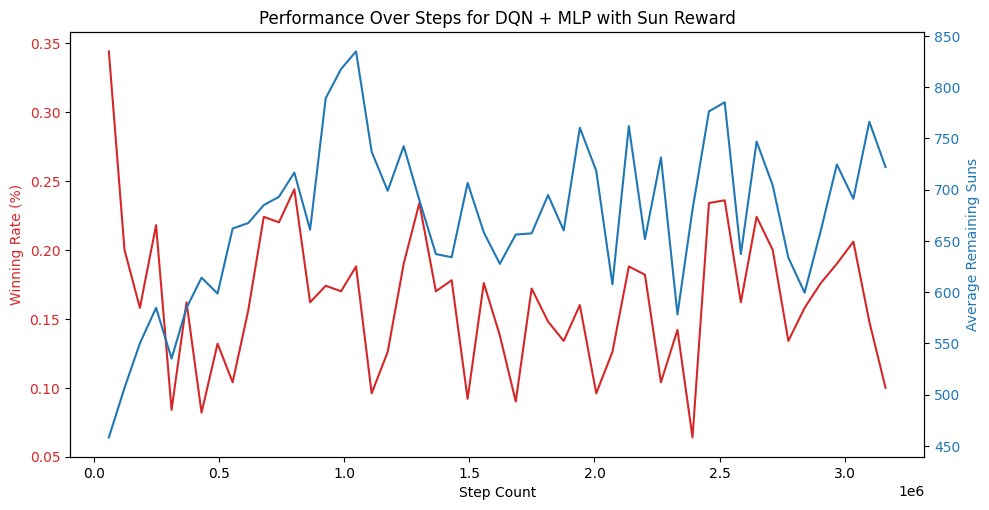

In [ ]:
agent.plot_stats_in_one_graph("Performance Over Steps for DQN + MLP with Sun Reward")

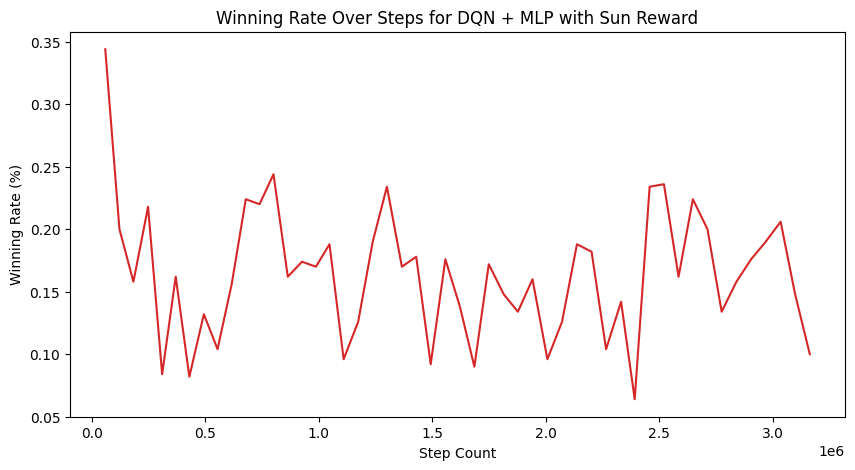

In [ ]:
agent.plot_stats_winning_rate("Winning Rate Over Steps for DQN + MLP with Sun Reward")

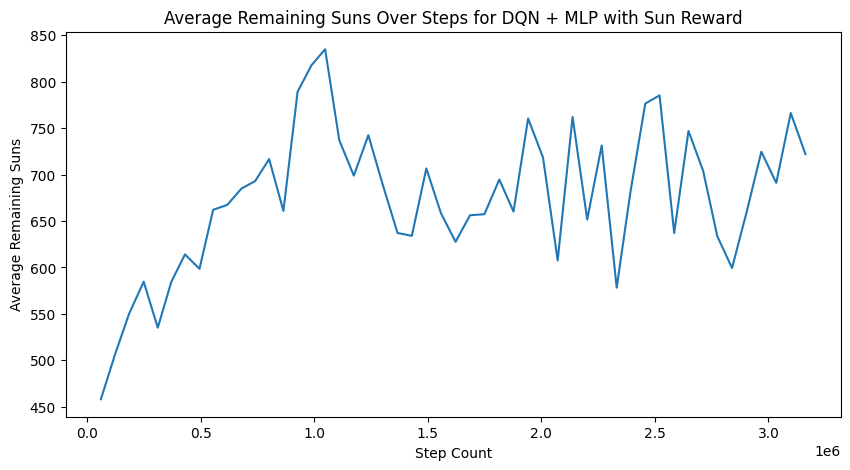

In [ ]:
agent.plot_stats_remaining_suns("Average Remaining Suns Over Steps for DQN + MLP with Sun Reward")

In [ ]:
agent.save_stats_to_csv("f2.csv")